In [1]:

!pip install pydicom opencv-python-headless scikit-image matplotlib
!pip install pylibjpeg pylibjpeg-libjpeg pydicom[gdcm]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.2 MB/s eta 0:00:00


In [2]:

import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure, filters
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from google.colab import files


In [3]:


def load_dicom_image(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize to [0,1]
    return img, ds

def show_image(img, title="Image"):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def compute_metrics(img):
    img64 = img.astype(np.float64)
    brightness = np.mean(img64)
    contrast = np.std(img64)
    sharpness = cv2.Laplacian(img64, cv2.CV_64F).var()
    noise_est = np.std(img64 - filters.gaussian(img64, sigma=1))

    return {
        'brightness': brightness,
        'contrast': contrast,
        'sharpness': sharpness,
        'noise': noise_est
    }

def static_preprocessing(img):
    img_eq = exposure.equalize_hist(img)
    img_denoised = cv2.GaussianBlur(img_eq, (3, 3), 0)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharp = cv2.filter2D(img_denoised, -1, kernel)
    return img_sharp

def adaptive_preprocessing(img, metrics):
    if metrics['contrast'] < 0.1:
        img = exposure.equalize_adapthist(img, clip_limit=0.03)

    if metrics['noise'] > 0.05:
        img = cv2.fastNlMeansDenoising((img * 255).astype(np.uint8), None, 10, 7, 21)
        img = img.astype(np.float32) / 255.0

    if metrics['sharpness'] < 5:
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        img = cv2.filter2D(img, -1, kernel)

    return img


In [4]:
DICOM files
uploaded = files.upload()


Saving R4.rvg to R4.rvg



📂 Processing: R4.rvg


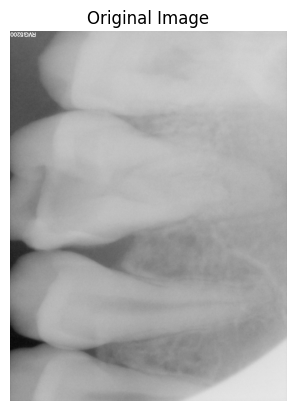

📊 Metrics: {'brightness': np.float64(0.6558294222618191), 'contrast': np.float64(0.12179868927728026), 'sharpness': np.float64(0.0017587548301287918), 'noise': np.float64(0.009046481085950232)}


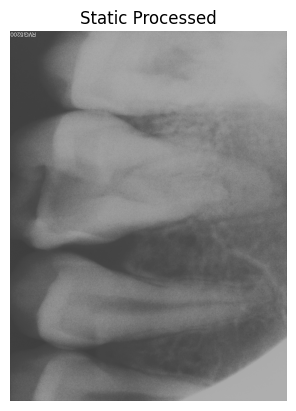

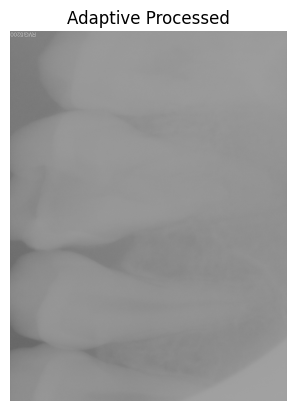

✅ PSNR: 27.55, SSIM: 0.5684


In [5]:

for img_path in uploaded.keys():
    print(f" Processing: {img_path}")

    # Load image and show original
    img, meta = load_dicom_image(img_path)
    show_image(img, "Original Image")

    # Compute quality metrics
    metrics = compute_metrics(img)
    print("Metrics:", metrics)

    img_static = static_preprocessing(img)
    show_image(img_static, "Static Processed")

    #preprocessing
    img_adaptive = adaptive_preprocessing(img, metrics)
    show_image(img_adaptive, "Adaptive Processed")

    # Evaluate
    psnr_val = psnr(img, img_adaptive)
    ssim_val = ssim(img, img_adaptive, data_range=1.0)
    print(f"PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")
